In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import numpy as np


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


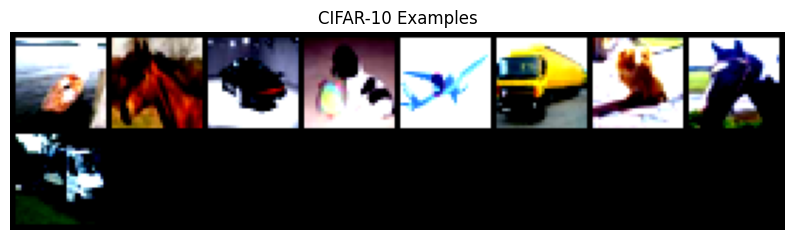

Labels: ['ship', 'horse', 'automobile', 'dog', 'airplane', 'truck', 'cat', 'horse', 'truck']


In [ ]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize with CIFAR-10 stats
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Define CIFAR-10 class names
class_names = train_dataset.classes

# Visualize a few examples
def show_images(dataset, num_images=9):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Unnormalize images for display
    images = images / 2 + 0.5  # Reverse normalization to range [0, 1]
    images = torchvision.utils.make_grid(images)
    np_images = images.numpy()
    
    # Plot images
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    plt.axis('off')
    plt.title("CIFAR-10 Examples")
    plt.show()

    # Print corresponding labels
    print("Labels:", [class_names[label] for label in labels])

# Show CIFAR-10 training examples
show_images(train_dataset)


In [10]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


In [11]:
def train_model(model, train_loader, test_loader, num_epochs=30):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies



Training GoogLeNet...
Epoch [1/30] - Train Loss: 2.1625, Train Acc: 22.74%, Val Loss: 2.1134, Val Acc: 25.73%
Epoch [2/30] - Train Loss: 1.9313, Train Acc: 30.12%, Val Loss: 1.6914, Val Acc: 37.59%
Epoch [3/30] - Train Loss: 1.7294, Train Acc: 36.62%, Val Loss: 1.5874, Val Acc: 40.98%
Epoch [4/30] - Train Loss: 1.5907, Train Acc: 41.90%, Val Loss: 1.5842, Val Acc: 45.15%
Epoch [5/30] - Train Loss: 1.4399, Train Acc: 47.49%, Val Loss: 1.4571, Val Acc: 51.44%
Epoch [6/30] - Train Loss: 1.3145, Train Acc: 52.08%, Val Loss: 1.2191, Val Acc: 56.96%
Epoch [7/30] - Train Loss: 1.1911, Train Acc: 57.11%, Val Loss: 1.0929, Val Acc: 59.96%
Epoch [8/30] - Train Loss: 1.0940, Train Acc: 61.02%, Val Loss: 1.0259, Val Acc: 63.73%
Epoch [9/30] - Train Loss: 1.0161, Train Acc: 64.06%, Val Loss: 1.0189, Val Acc: 63.44%
Epoch [10/30] - Train Loss: 0.9469, Train Acc: 66.46%, Val Loss: 0.9624, Val Acc: 67.07%
Epoch [11/30] - Train Loss: 0.9111, Train Acc: 68.20%, Val Loss: 0.8236, Val Acc: 71.35%
Epoch [

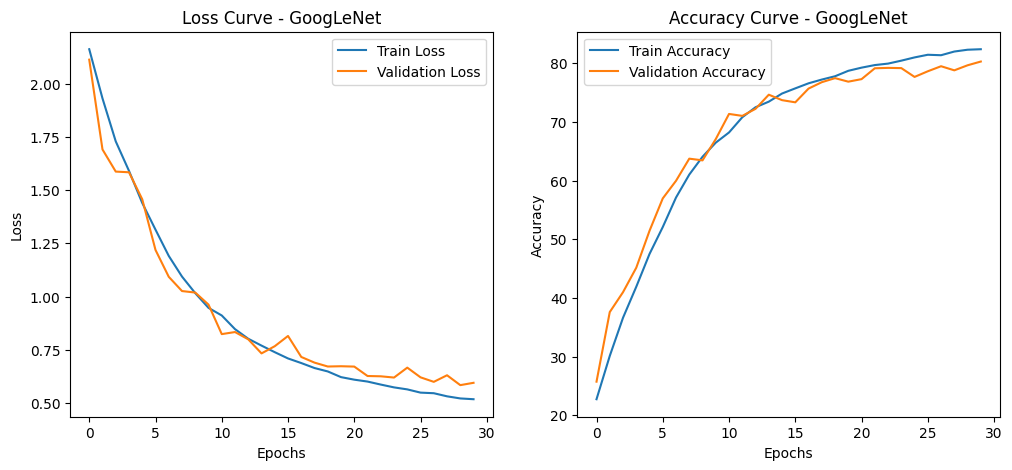

In [8]:
# Define GoogLeNet with auxiliary logits disabled
googlenet_model = models.googlenet(pretrained=False, num_classes=10, aux_logits=False).to(device)

# Train GoogLeNet
print("\nTraining GoogLeNet...")
googlenet_results = train_model(googlenet_model, train_loader, test_loader)

# Plot Results for GoogLeNet
train_losses, train_accuracies, val_losses, val_accuracies = googlenet_results
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve - GoogLeNet')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - GoogLeNet')
plt.legend()

plt.show()


c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Training ResNet-18...


c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30] - Train Loss: 1.7342, Train Acc: 38.99%, Val Loss: 1.5492, Val Acc: 49.81%
Epoch [2/30] - Train Loss: 1.3666, Train Acc: 52.00%, Val Loss: 1.0907, Val Acc: 61.30%
Epoch [3/30] - Train Loss: 1.1597, Train Acc: 59.46%, Val Loss: 1.1245, Val Acc: 62.24%
Epoch [4/30] - Train Loss: 1.0433, Train Acc: 63.46%, Val Loss: 0.9269, Val Acc: 68.02%
Epoch [5/30] - Train Loss: 0.9544, Train Acc: 66.35%, Val Loss: 0.9003, Val Acc: 68.16%
Epoch [6/30] - Train Loss: 0.8879, Train Acc: 69.04%, Val Loss: 0.8413, Val Acc: 71.45%
Epoch [7/30] - Train Loss: 0.8379, Train Acc: 70.77%, Val Loss: 0.8261, Val Acc: 72.70%
Epoch [8/30] - Train Loss: 0.7991, Train Acc: 71.88%, Val Loss: 0.7919, Val Acc: 73.51%
Epoch [9/30] - Train Loss: 0.7621, Train Acc: 73.24%, Val Loss: 0.8146, Val Acc: 72.16%
Epoch [10/30] - Train Loss: 0.7271, Train Acc: 74.50%, Val Loss: 0.7237, Val Acc: 75.50%
Epoch [11/30] - Train Loss: 0.7034, Train Acc: 75.44%, Val Loss: 0.7110, Val Acc: 75.06%
Epoch [12/30] - Train Loss: 0.

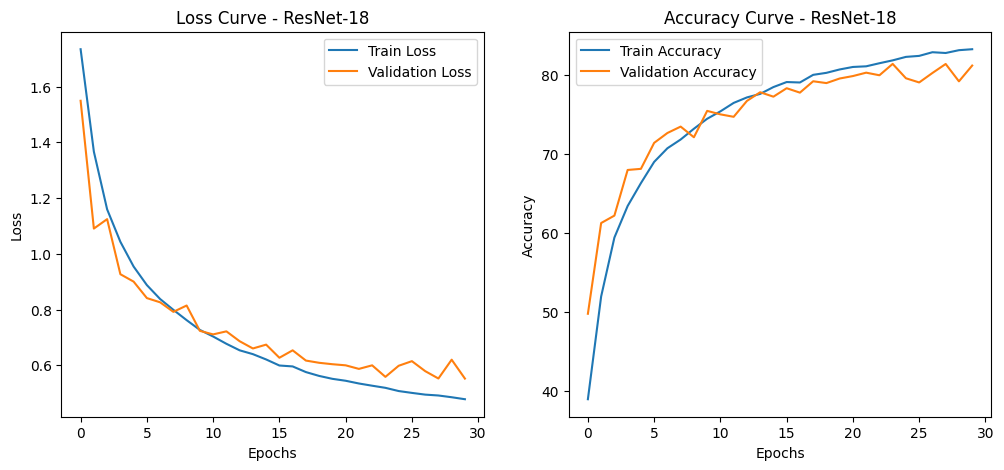

In [12]:
# Define ResNet-18
resnet18_model = models.resnet18(pretrained=False, num_classes=10).to(device)

# Train ResNet-18
print("\nTraining ResNet-18...")
resnet18_results = train_model(resnet18_model, train_loader, test_loader)

# Plot Results for ResNet-18
train_losses, train_accuracies, val_losses, val_accuracies = resnet18_results
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve - ResNet-18')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - ResNet-18')
plt.legend()

plt.show()



Training ResNet-34...
Epoch [1/30] - Train Loss: 1.9030, Train Acc: 34.26%, Val Loss: 3.1897, Val Acc: 39.92%
Epoch [2/30] - Train Loss: 1.5473, Train Acc: 45.73%, Val Loss: 3.0083, Val Acc: 48.85%
Epoch [3/30] - Train Loss: 1.3426, Train Acc: 52.60%, Val Loss: 1.3427, Val Acc: 53.83%
Epoch [4/30] - Train Loss: 1.2034, Train Acc: 57.72%, Val Loss: 1.1306, Val Acc: 61.71%
Epoch [5/30] - Train Loss: 1.0999, Train Acc: 61.40%, Val Loss: 0.9828, Val Acc: 64.95%
Epoch [6/30] - Train Loss: 0.9940, Train Acc: 65.14%, Val Loss: 0.9038, Val Acc: 68.71%
Epoch [7/30] - Train Loss: 0.9365, Train Acc: 67.24%, Val Loss: 0.8671, Val Acc: 70.41%
Epoch [8/30] - Train Loss: 0.8629, Train Acc: 69.95%, Val Loss: 0.8530, Val Acc: 70.18%
Epoch [9/30] - Train Loss: 0.8245, Train Acc: 71.33%, Val Loss: 0.7914, Val Acc: 72.57%
Epoch [10/30] - Train Loss: 0.7923, Train Acc: 72.50%, Val Loss: 0.7559, Val Acc: 73.91%
Epoch [11/30] - Train Loss: 0.7437, Train Acc: 74.20%, Val Loss: 0.7610, Val Acc: 74.05%
Epoch [

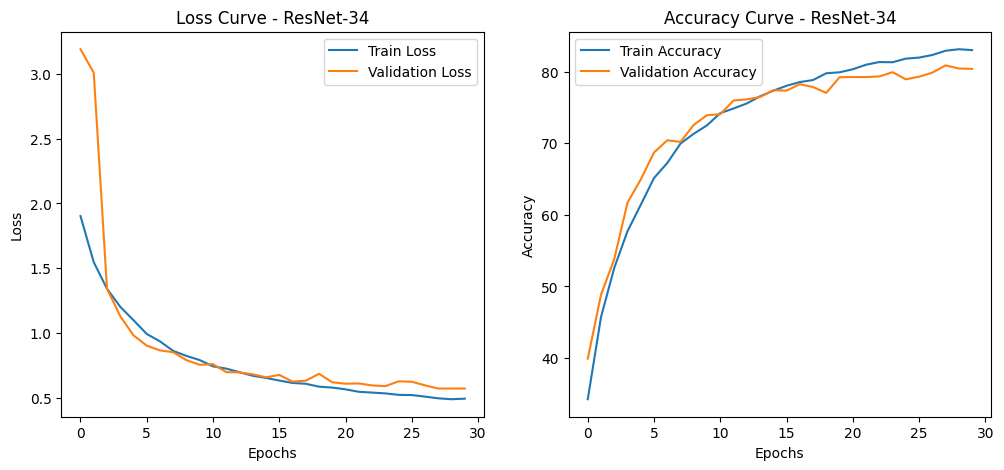

In [13]:
# Define ResNet-34
resnet34_model = models.resnet34(pretrained=False, num_classes=10).to(device)

# Train ResNet-34
print("\nTraining ResNet-34...")
resnet34_results = train_model(resnet34_model, train_loader, test_loader)

# Plot Results for ResNet-34
train_losses, train_accuracies, val_losses, val_accuracies = resnet34_results
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve - ResNet-34')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - ResNet-34')
plt.legend()

plt.show()


c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Antomiao/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 11.6MB/s]
c:\Users\Antomiao\AppData\Local\Programs\Python\Python39\lib\


Training EfficientNet-B0...
Epoch [1/30] - Train Loss: 2.3256, Train Acc: 28.63%, Val Loss: 1.5384, Val Acc: 43.96%
Epoch [2/30] - Train Loss: 1.5282, Train Acc: 44.65%, Val Loss: 1.2797, Val Acc: 53.81%
Epoch [3/30] - Train Loss: 1.3170, Train Acc: 52.73%, Val Loss: 1.1231, Val Acc: 59.75%
Epoch [4/30] - Train Loss: 1.1608, Train Acc: 58.95%, Val Loss: 1.0113, Val Acc: 63.89%
Epoch [5/30] - Train Loss: 1.0598, Train Acc: 62.53%, Val Loss: 0.9413, Val Acc: 66.26%
Epoch [6/30] - Train Loss: 0.9728, Train Acc: 65.65%, Val Loss: 0.8774, Val Acc: 69.04%
Epoch [7/30] - Train Loss: 0.9250, Train Acc: 67.73%, Val Loss: 0.8240, Val Acc: 71.42%
Epoch [8/30] - Train Loss: 0.8632, Train Acc: 69.96%, Val Loss: 0.7397, Val Acc: 74.43%
Epoch [9/30] - Train Loss: 0.8395, Train Acc: 70.90%, Val Loss: 0.8016, Val Acc: 71.61%
Epoch [10/30] - Train Loss: 0.9114, Train Acc: 68.47%, Val Loss: 0.7604, Val Acc: 73.03%
Epoch [11/30] - Train Loss: 0.8643, Train Acc: 69.94%, Val Loss: 0.9874, Val Acc: 66.43%
E

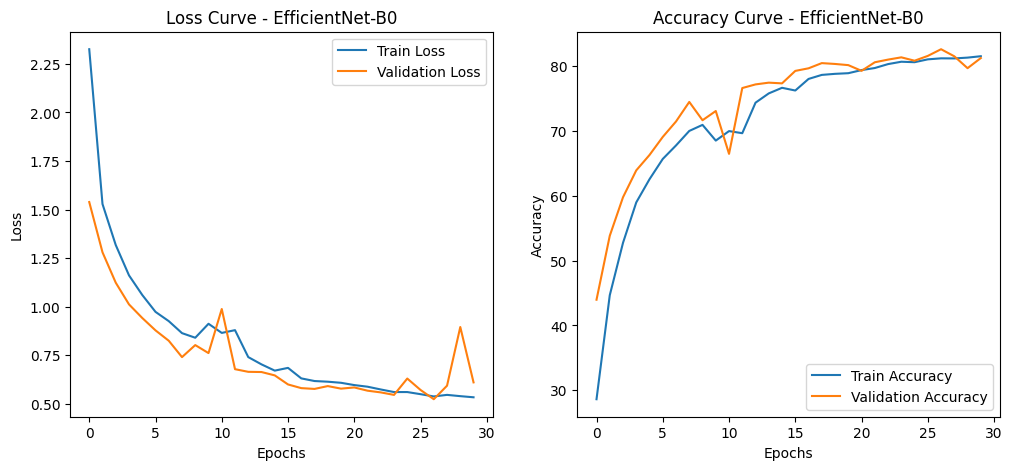

In [19]:
# Define EfficientNet-B0
efficientnet_model = models.efficientnet_b0(pretrained=True).to(device)

# Train EfficientNet-B0
print("\nTraining EfficientNet-B0...")
efficientnet_results = train_model(efficientnet_model, train_loader, test_loader)

# Plot Results for EfficientNet-B0
train_losses, train_accuracies, val_losses, val_accuracies = efficientnet_results
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve - EfficientNet-B0')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - EfficientNet-B0')
plt.legend()

plt.show()
